In [12]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.compiler import transpile
from qiskit.visualization import plot_histogram, plot_distribution
import numpy as np
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from dotenv import load_dotenv
import os

In [62]:
def build_oracle(qc, gates):
    """
    Append gates to the given quantum circuit.
    """
    for gate_name, gate_target in gates:
        gate = getattr(qc, gate_name)
        gate(*gate_target)

    return qc


In [63]:
def phase_oracle(n, gates_to_apply, name="oracle"):
    qc = QuantumCircuit(n, name=name)
    build_oracle(qc, gates_to_apply)
    return qc

In [64]:
def diffuser(n, gates_to_apply, name="diffuser"):
    qc = QuantumCircuit(n, name=name)

    for qb in range(n - 2):
        qc.h(qb)
    for i in range(n - 2):
        qc.x(i)

    build_oracle(qc, gates_to_apply)

    for i in range(n - 2):
        qc.x(i)
    for qb in range(n - 2):
        qc.h(qb)
    return qc

In [65]:
def grover_algorithm(grover_bits, gates_steps, mu):
    # In the given example, there are three qubit programs,
    # the fourth qubit is the zero qubit reference and fifth one 
    # is to insert the ancilla qubit minus state
    n = grover_bits
    gr = QuantumCircuit(n, n - 2)

    # Number of solutions
    iterations = int(np.floor(np.pi / 4 * np.sqrt(2 ** (n - 2)) / mu))

    #iterations = int(np.pi/4 * np.sqrt(2**(n - 2)))

    print(f'Oracle and diffuser applied {iterations} time(s)')

    # Step 1: apply Hadamard gates on all working qubits
    gr.h(range(n - 2)) 

    # Put ancilla in minus state |->
    gr.x(n - 1)
    gr.h(n - 1)

    # Step 2: apply r rounds of the phase oracle and the diffuser
    for r in range(iterations):
        gr.append(phase_oracle(n, gates_steps), range(n))
        gr.append(diffuser(n, gates_steps), range(n))

    gr.measure(range(n - 2), range(n - 2))

    return gr


In [91]:
def transpile_circuit(grover_circuit):
        
    simulator = AerSimulator()
    transpiled_qc = transpile(grover_circuit, simulator)
    job = simulator.run(transpiled_qc, shots=500)
    result = job.result()
    counts = result.get_counts()
    
    print("Counts:", counts)
    display(plot_histogram(counts, title='Simulator results'))

In [92]:
from qiskit.primitives import SamplerPubResult, BitArray


def transpile_circuit_quantum(grover_circuit):
    load_dotenv(dotenv_path="../.env")
    ibm_token = os.getenv("IBM_TOKEN")

    QiskitRuntimeService.save_account(channel="ibm_quantum",
								  token=ibm_token, overwrite=True,
								  set_as_default=True)
    service = QiskitRuntimeService()
    backend = service.least_busy(operational=True, simulator=False)
    print(f"Using backend: {backend.name}")

    target = backend.target
    pass_manager = generate_preset_pass_manager(target=target, optimization_level=2, backend=backend)
    
    transpiled = pass_manager.run(grover_circuit)

    #display(transpiled.draw("mpl", idle_wires=False, style="iqp"))

    sampler = Sampler(mode=backend)

    sampler.options.dynamical_decoupling.enable = True
    sampler.options.twirling.enable_gates = True
    
    job = sampler.run([transpiled], shots=500)
    
    
    job_id = job.job_id()
    print(job_id)

    #result = job.result()
    result = job.result()._pub_results

    plot_data = [SamplerPubResult.join_data(r) for r in result]
    counts = [BitArray.get_counts(pd, None) for pd in plot_data]

    display(plot_distribution(counts, title="Quantum results"))

<br/>

**Oracle 1**


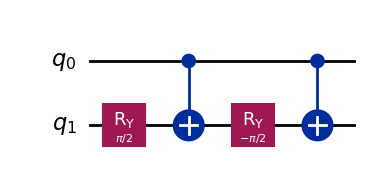

Oracle and diffuser applied 1 time(s)
Counts: {'01': 500}


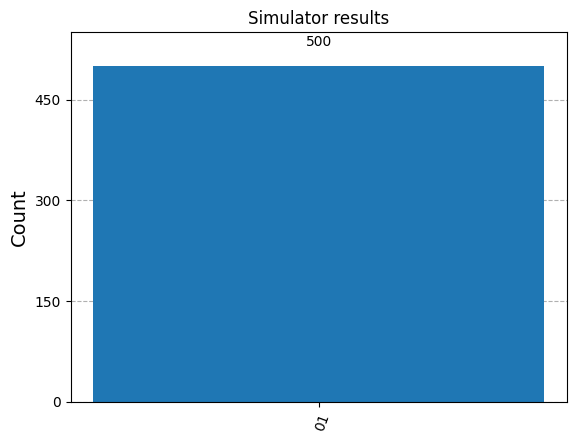

In [93]:
gates = [
    ("ry", [np.pi/2, 1]),
    ("cx", [0, 1]),
    ("ry", [-np.pi/2, 1]),
    ("cx", [0, 1]),
]

'''
|00⟩ → |00⟩
|01⟩ → -|01⟩ (phase change)
|10⟩ → |10⟩
|11⟩ → |11⟩
'''

nqubits = 2
qc = QuantumCircuit(nqubits)
qc = build_oracle(qc, gates)
display(qc.draw(output='mpl'))

nqubitsctrl = nqubits + 2
oracle = QuantumCircuit(nqubitsctrl)

solutions = 1

gr = grover_algorithm(nqubitsctrl, gates, solutions)

transpile_circuit(gr)

In [94]:
gates = [
    ("ry", [np.pi/2, 1]),
    ("cx", [0, 1]),
    ("ry", [-np.pi/2, 1]),
    ("cx", [0, 1]),
]

nqubits = 2
nqubitsctrl = nqubits + 2
oracle = QuantumCircuit(nqubitsctrl)
build_oracle(oracle, gates)

solutions = 1

gr = grover_algorithm(nqubitsctrl, gates, solutions)

transpile_circuit_quantum(gr)

Oracle and diffuser applied 1 time(s)
Using backend: ibm_sherbrooke
cvtpt2gmfgf000861p9g


KeyboardInterrupt: 

<br/>

**Oracle 2**


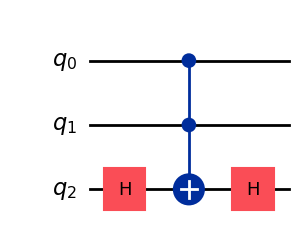

Oracle and diffuser applied 2 time(s)
Counts: {'101': 2, '010': 3, '000': 6, '100': 3, '110': 4, '011': 5, '111': 477}


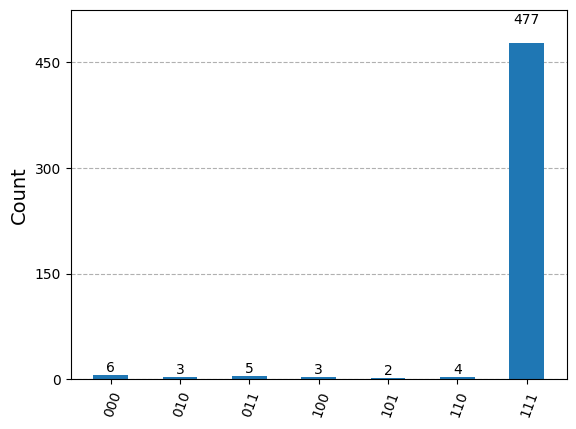

In [74]:
gates = [
    ("h", [2]),
    ("ccx", [0, 1, 2]),
    ("h", [2]),
]
'''
qc.ccx(0, 1, 2)
- Toffoli gate (CCX) in qubits 0, 1, and 2:
- CCX controled controled NOT gate.
- Inverts qubit 2 only if qubits 0 and 1 are in |1⟩

- After H - CCX - H the state of the sitem is:
a|000⟩ + b|001⟩ + c|010⟩ + d|011⟩ + e|100⟩ + f|101⟩ + g|110⟩ - h|111⟩
'''

nqubits = 3

qc = QuantumCircuit(nqubits)
qc = build_oracle(qc, gates)
display(qc.draw(output='mpl'))


nqubitsctrl = nqubits + 2
solutions = 1

oracle = QuantumCircuit(nqubitsctrl)
build_oracle(oracle, gates)

solutions = 1

gr = grover_algorithm(nqubitsctrl, gates, solutions)

transpile_circuit(gr)

Oracle and diffuser applied 2 time(s)
Using backend: ibm_sherbrooke
cvtntahjf1b0008cczxg


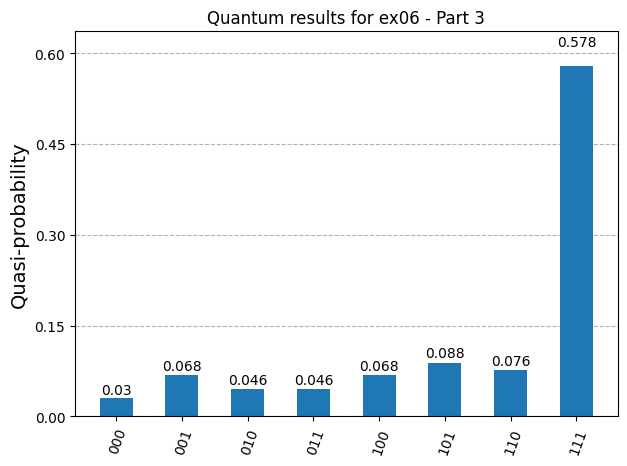

In [10]:
gates = [
    ("h", [2]),
    ("ccx", [0, 1, 2]),
    ("h", [2]),
]

nqubits = 3
nqubitsctrl = nqubits + 2
oracle = QuantumCircuit(nqubitsctrl)
build_oracle(oracle, gates)

solutions = 1

gr = grover_algorithm(nqubitsctrl, gates, solutions)

transpile_circuit_quantum(gr)

<br/>

**Oracle 3**


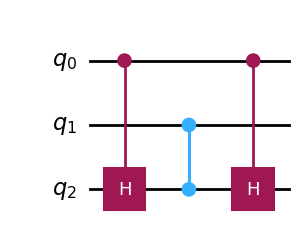

Oracle and diffuser applied 2 time(s)
Counts: {'101': 5, '000': 2, '010': 2, '111': 25, '011': 36, '110': 37, '001': 211, '100': 182}


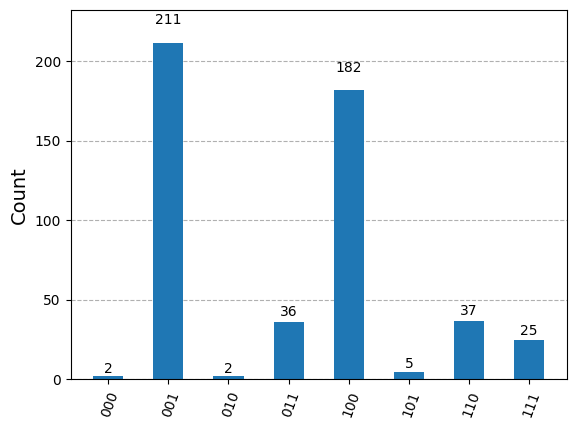

In [82]:
gates = [
    ("ch", (0, 2)),
    ("cz", (1, 2)),
    ("ch", (0, 2)),
]

nqubits = 3

qc = QuantumCircuit(nqubits)
qc = build_oracle(qc, gates)
display(qc.draw(output='mpl'))

nqubitsctrl = nqubits + 2
oracle = QuantumCircuit(nqubitsctrl)
build_oracle(oracle, gates)

solutions = 1

gr = grover_algorithm(nqubitsctrl, gates, solutions)

transpile_circuit(gr)

Oracle and diffuser applied 2 time(s)
Using backend: ibm_sherbrooke
cvtp5bx7ceng008pnn80


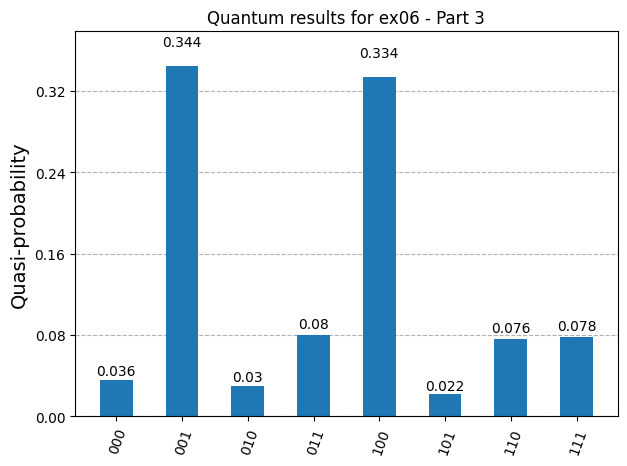

In [44]:
gates = [
    ("ch", (0, 2)),
    ("cz", (1, 2)),
    ("ch", (0, 2)),
]

nqubits = 3
nqubitsctrl = nqubits + 2
oracle = QuantumCircuit(nqubitsctrl)
build_oracle(oracle, gates)

solutions = 1

gr = grover_algorithm(nqubitsctrl, gates, solutions)

transpile_circuit_quantum(gr)

<br/>

**Oracle 4**


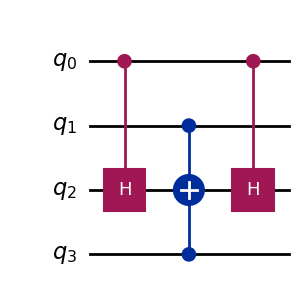

Oracle and diffuser applied 3 time(s)
Counts: {'1011': 4, '1110': 258, '1001': 3, '0101': 18, '1100': 37, '1000': 2, '0110': 49, '1101': 7, '0100': 40, '1010': 47, '0111': 17, '0011': 2, '0010': 2, '0000': 2, '1111': 11, '0001': 1}


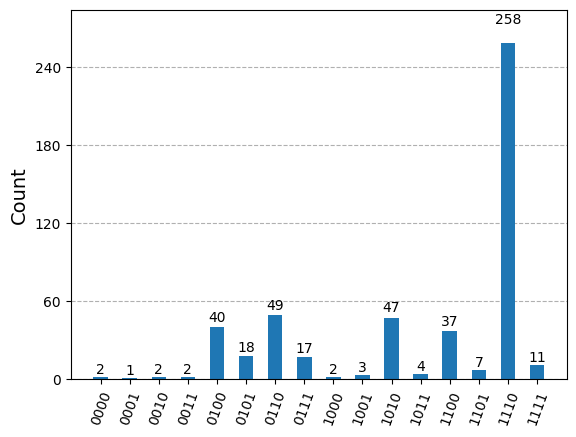

In [76]:
gates = [
    ("ch", [0, 2]),
    ("ccx", [1, 3, 2]),
    ("ch", [0, 2]),
]

nqubits = 4

qc = QuantumCircuit(nqubits)
qc = build_oracle(qc, gates)
display(qc.draw(output='mpl'))

nqubitsctrl = nqubits + 2
oracle = QuantumCircuit(nqubitsctrl)
build_oracle(oracle, gates)

solutions = 1

gr = grover_algorithm(nqubitsctrl, gates, solutions)

transpile_circuit(gr)

Oracle and diffuser applied 3 time(s)
Using backend: ibm_sherbrooke
cvtp87gjf1b0008cd0y0


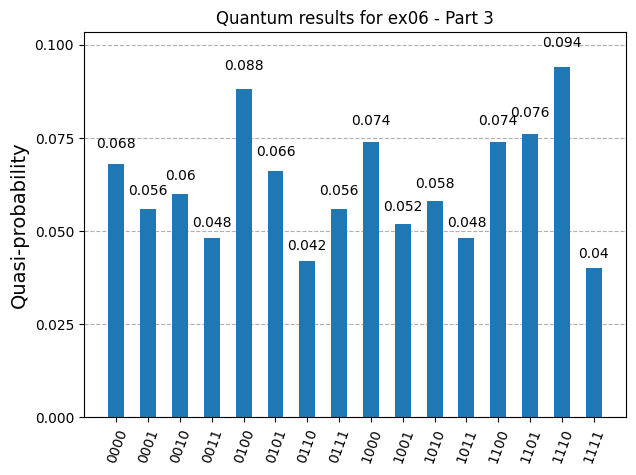

In [47]:
gates = [
    ("ch", [0, 2]),
    ("ccx", [1, 3, 2]),
    ("ch", [0, 2]),
]

nqubits = 4
nqubitsctrl = nqubits + 2
oracle = QuantumCircuit(nqubitsctrl)
build_oracle(oracle, gates)

solutions = 1

gr = grover_algorithm(nqubitsctrl, gates, solutions)

transpile_circuit_quantum(gr)

<br/>

**Oracle 5**


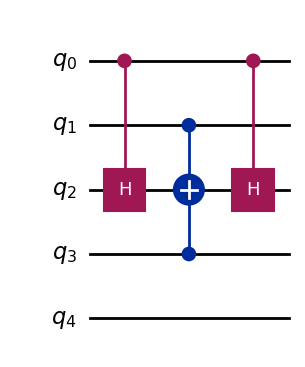

Oracle and diffuser applied 2 time(s)
Counts: {'00010': 3, '11001': 3, '01101': 4, '00000': 1, '01011': 3, '11000': 3, '11111': 55, '00011': 2, '00111': 10, '11101': 3, '10100': 31, '01110': 61, '01001': 2, '10001': 2, '00101': 9, '11110': 66, '10110': 33, '01111': 51, '00001': 2, '10111': 2, '10010': 2, '10101': 5, '11100': 32, '01100': 34, '01000': 2, '00110': 38, '11011': 3, '10000': 3, '00100': 35}


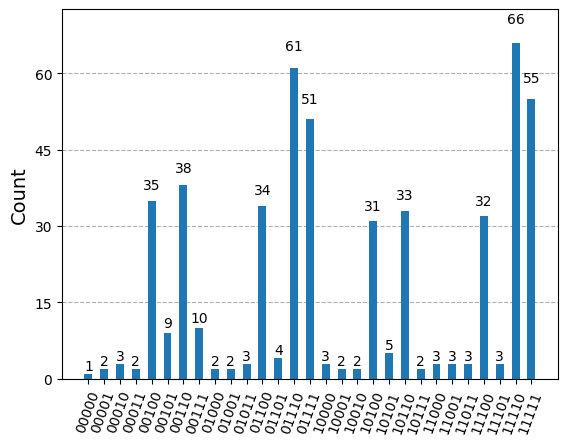

In [79]:
gates = [
    ("ch", [0, 2]),
    ("ccx", [1, 3, 2]),
    ("ch", [0, 2]),
]

nqubits = 5

qc = QuantumCircuit(nqubits)
qc = build_oracle(qc, gates)
display(qc.draw(output='mpl'))

nqubitsctrl = nqubits + 2
oracle = QuantumCircuit(nqubitsctrl)
build_oracle(oracle, gates)

solutions = 2

gr = grover_algorithm(nqubitsctrl, gates, solutions)

transpile_circuit(gr)

Oracle and diffuser applied 4 time(s)
Using backend: ibm_sherbrooke
cvtpmqajf1b0008cd1yg


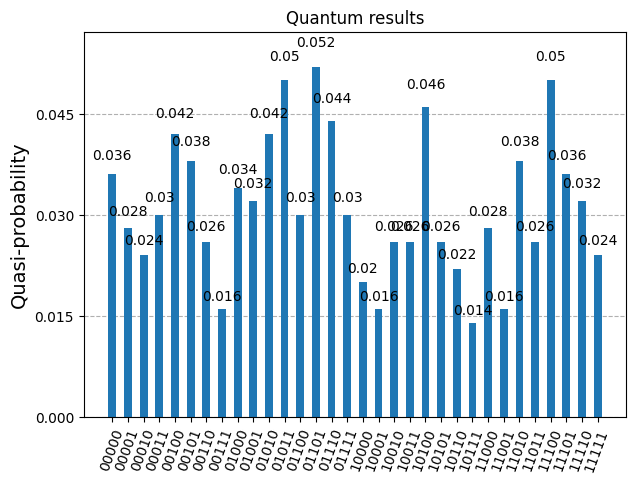

In [78]:
gates = [
    ("ch", [0, 2]),
    ("ccx", [1, 3, 2]),
    ("ch", [0, 2]),
]

nqubits = 5
nqubitsctrl = nqubits + 2
oracle = QuantumCircuit(nqubitsctrl)
build_oracle(oracle, gates)

solutions = 1

gr = grover_algorithm(nqubitsctrl, gates, solutions)

transpile_circuit_quantum(gr)